# 0. Inspect Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
X_train = pd.read_csv('data/X_train.csv', index_col=0)
y_train = pd.read_csv('data/y_train.csv', index_col=0)

In [3]:
X_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
id,,,,,,,,,,,,,,,,,,,,,
0.0,14168.823171,10514.380717,3316.149698,94230.695124,102.386606,92.677127,11108.748199,10866.505510,10837.622093,10.227734,...,NaN,12352.094085,846.014651,105.132144,102.112809,2090.004260,2.691845,1234.374109,1000.784475,9285.751272
1.0,17757.037554,NaN,4101.016273,92959.527633,NaN,99.855168,10013.959449,10826.607494,10076.101597,11.436970,...,NaN,16198.071494,776.084467,106.385590,103.472030,2474.051881,2.287976,NaN,1012.626705,11750.284764
2.0,14226.656663,11029.642499,NaN,124055.600561,100.542483,92.860892,NaN,10492.342868,NaN,10.810076,...,10329.704431,13976.063780,737.040332,103.671234,109.458246,2656.083281,2.843706,888.353607,1048.810385,9553.922728
3.0,8766.012436,7384.202998,2147.308418,100157.719990,104.855061,101.929026,10050.049932,10499.521099,10525.030989,10.092109,...,10008.251395,6212.127347,329.044233,105.084488,104.858546,1097.785204,2.732257,927.752967,1048.357330,NaN
4.0,13801.016418,13269.493652,3408.316953,92048.527786,103.759758,95.789235,9667.353978,10750.783106,10618.800750,12.006773,...,10095.782015,13772.061493,NaN,NaN,100.369834,2693.053231,2.702908,1471.354073,1071.284484,9423.533063


In [4]:
X_train.shape

(1212, 832)

let's see how many NaN's there are per column

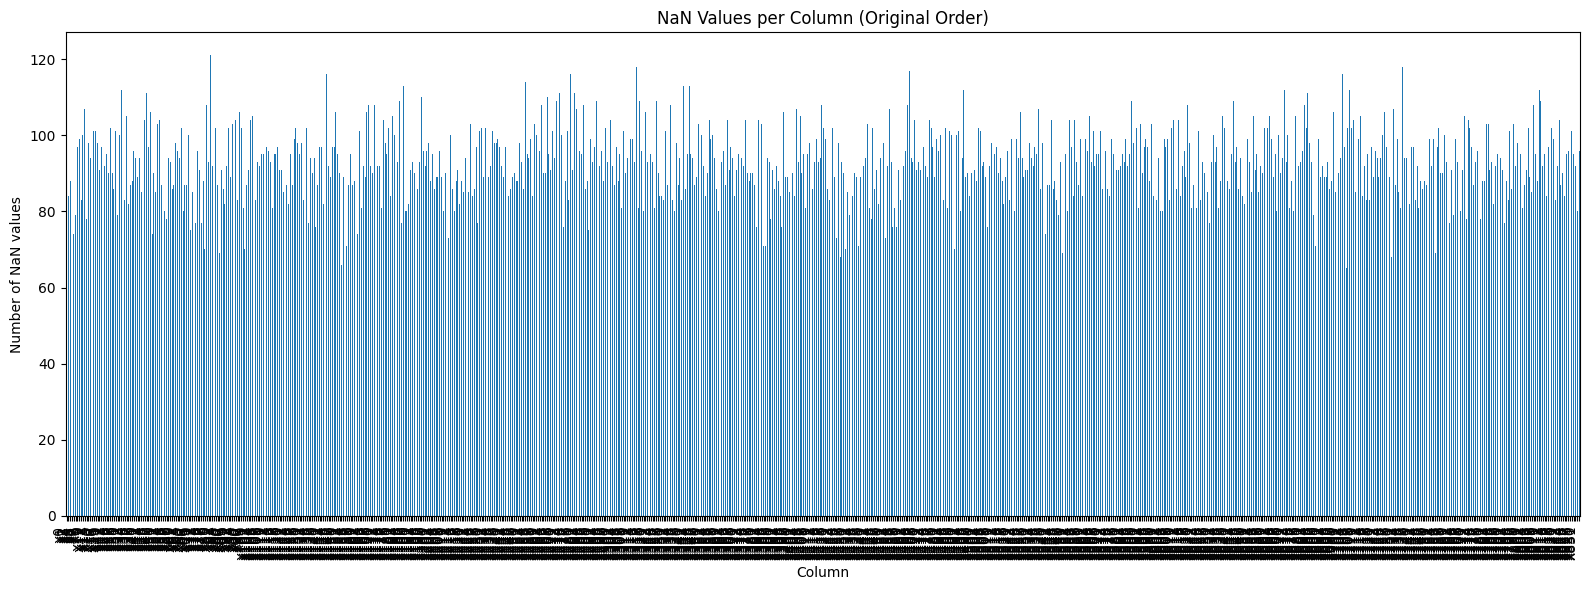

In [5]:
nans = X_train.isna().sum()

# Plot all columns in their original order
nans.plot(kind='bar', figsize=(16, 6))
plt.xlabel('Column')
plt.ylabel('Number of NaN values')
plt.title('NaN Values per Column (Original Order)')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

# 1. Imputation of Missing Values
- First, we impute all missing values by the median value of the feature. 
- Then, we remove any features with zero variance

In [6]:
# temporarily impute NaNs with median value
X_train.fillna(X_train.median(), inplace=True)

In [7]:
# detect features with zero variance
zero_variance_columns = X_train.columns[X_train.nunique() <= 1].tolist()
print(f"Columns with zero variance: {zero_variance_columns}")

# remove these columns from the dataset
X_train.drop(columns=zero_variance_columns, inplace=True)
X_train.shape

Columns with zero variance: ['x104', 'x129', 'x489', 'x530']


(1212, 828)

# 2. Outlier Detection

Common methods for detecting outliers:
- **Z-score**: Values with |z-score| > 3
- **IQR Method**: Values beyond 1.5 * IQR from Q1/Q3
- **Isolation Forest**: ML-based anomaly detection

In [8]:
# Method 1: Z-score approach
import numpy as np
from scipy import stats

# Calculate z-scores for all features
z_scores = np.abs(stats.zscore(X_train))

# Find rows where any feature has |z-score| > 3
outlier_mask_zscore = (z_scores > 3).any(axis=1)
outlier_rows_zscore = np.where(outlier_mask_zscore)[0]

print(f"Z-score method:")
print(f"  Outlier rows: {len(outlier_rows_zscore)} ({len(outlier_rows_zscore)/len(X_train)*100:.2f}%)")

Z-score method:
  Outlier rows: 984 (81.19%)


In [9]:
# Method 2: IQR (Interquartile Range) approach
Q1 = np.percentile(X_train, 25, axis=0)
Q3 = np.percentile(X_train, 75, axis=0)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find rows with values outside bounds
outlier_mask_iqr = ((X_train < lower_bound) | (X_train > upper_bound)).any(axis=1)
outlier_rows_iqr = np.where(outlier_mask_iqr)[0]

print(f"IQR method:")
print(f"  Outlier rows: {len(outlier_rows_iqr)} ({len(outlier_rows_iqr)/len(X_train)*100:.2f}%)")

IQR method:
  Outlier rows: 1210 (99.83%)


In [10]:
# Method 3: Isolation Forest (ML-based)
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.1, random_state=42)
outlier_predictions = iso_forest.fit_predict(X_train)

# -1 indicates outlier, 1 indicates inlier
outlier_mask_isoforest = outlier_predictions == -1
outlier_rows_isoforest = np.where(outlier_mask_isoforest)[0]

print(f"Isolation Forest:")
print(f"  Outlier rows: {len(outlier_rows_isoforest)} ({len(outlier_rows_isoforest)/len(X_train)*100:.2f}%)")

Isolation Forest:
  Outlier rows: 122 (10.07%)


In [11]:
# Analyze row-level outlier overlap across methods
print("\n=== Row-Level Outlier Analysis ===")

# Create sets for easier comparison
set_zscore = set(outlier_rows_zscore)
set_iqr = set(outlier_rows_iqr)
set_isoforest = set(outlier_rows_isoforest)

# Find rows flagged by different numbers of methods
rows_by_all_3 = set_zscore & set_iqr & set_isoforest
rows_by_exactly_2 = (
    (set_zscore & set_iqr) | (set_zscore & set_isoforest) | (set_iqr & set_isoforest)
) - rows_by_all_3
rows_by_any = set_zscore | set_iqr | set_isoforest
rows_by_exactly_1 = rows_by_any - rows_by_exactly_2 - rows_by_all_3

print(f"\nRows flagged by all 3 methods: {len(rows_by_all_3)}")
print(f"Rows flagged by exactly 2 methods: {len(rows_by_exactly_2)}")
print(f"Rows flagged by exactly 1 method: {len(rows_by_exactly_1)}")
print(f"Total rows with outliers: {len(rows_by_any)}")

# Store for later use
outlier_data = {
    'all_3_methods': sorted(list(rows_by_all_3)),
    'exactly_2_methods': sorted(list(rows_by_exactly_2)),
    'exactly_1_method': sorted(list(rows_by_exactly_1)),
    'any_method': sorted(list(rows_by_any))
}


=== Row-Level Outlier Analysis ===

Rows flagged by all 3 methods: 110
Rows flagged by exactly 2 methods: 886
Rows flagged by exactly 1 method: 214
Total rows with outliers: 1210


In [12]:
# Remove outliers detected by all 3 methods
rows_to_remove = outlier_data['all_3_methods']
X_train_clean = X_train.drop(index=X_train.index[rows_to_remove])
y_train_clean = y_train.drop(index=y_train.index[rows_to_remove])

print(f"Original dataset: {X_train.shape}")
print(f"After removing outliers (all 3 methods): {X_train_clean.shape} - removed {len(rows_to_remove)} rows")

Original dataset: (1212, 828)
After removing outliers (all 3 methods): (1102, 828) - removed 110 rows


# 3. Feature Selection

Methods used to select the most important features:
- **SelectKBest**: Univariate statistical tests (F-scores) for each feature independently
- **Random Forest**: Tree-based feature importance capturing feature interactions
- **Combined Ranking**: Normalized average of both methods for robust feature selection

In [13]:
# Method 1: SelectKBest (Univariate Statistical Test)
from sklearn.feature_selection import SelectKBest, f_regression

kbest = SelectKBest(score_func=f_regression, k="all")
kbest.fit(X_train_clean, y_train_clean["y"])

feature_scores_kbest = pd.DataFrame({
    'feature': X_train_clean.columns,
    'score': kbest.scores_
}).sort_values('score', ascending=False)

print("SelectKBest - Top 10 features:")
print(feature_scores_kbest.head(10))

SelectKBest - Top 10 features:
    feature       score
483    x485  276.926518
456    x458  270.903244
192    x194  266.764771
157    x159  265.097000
131    x133  264.910703
413    x415  245.681036
463    x465  241.865366
504    x507  238.067634
332    x334  237.180454
698    x702  231.007342


/Users/melanie/Desktop/workspace/aml-23/aml/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:381: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)


In [14]:
# Method 2: Random Forest (Tree-based Feature Importance)
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_clean, y_train_clean["y"])

feature_scores_rf = pd.DataFrame({
    'feature': X_train_clean.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nRandom Forest - Top 10 features:")
print(feature_scores_rf.head(10))


Random Forest - Top 10 features:
    feature  importance
114    x115    0.265545
413    x415    0.029370
504    x507    0.022467
738    x742    0.022179
456    x458    0.020540
332    x334    0.015334
637    x641    0.015329
131    x133    0.012997
323    x325    0.009171
192    x194    0.008574


In [ ]:
# Combine rankings from both methods
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
feature_scores_kbest['normalized_score'] = scaler.fit_transform(feature_scores_kbest[['score']])
feature_scores_rf['normalized_importance'] = scaler.fit_transform(feature_scores_rf[['importance']])

comparison = feature_scores_kbest.merge(
    feature_scores_rf[['feature', 'importance', 'normalized_importance']], 
    on='feature'
)
comparison['combined_score'] = (comparison['normalized_score'] + comparison['normalized_importance']) / 2
comparison = comparison.sort_values('combined_score', ascending=False)

print("\nCombined Ranking - Top 20 features:")
print(comparison[['feature', 'score', 'importance', 'combined_score']].head(20))


Combined Ranking - Top 20 features:
   feature       score  importance  combined_score
10    x115  217.464501    0.265545        0.892639
1     x458  270.903244    0.020540        0.527793
0     x485  276.926518    0.008427        0.515860
4     x133  264.910703    0.012997        0.502770
5     x415  245.681036    0.029370        0.498879
2     x194  266.764771    0.008574        0.497790
3     x159  265.097000    0.004798        0.487668
7     x507  238.067634    0.022467        0.472136
8     x334  237.180454    0.015334        0.457103
6     x465  241.865366    0.008423        0.452547
9     x702  231.007342    0.004240        0.425067
11    x200  214.565108    0.006170        0.399015
12    x654  196.167993    0.004495        0.362643
13    x362  185.042251    0.004625        0.342800
14    x712  184.834198    0.001492        0.336525
15    x287  179.868300    0.002640        0.329722
16    x410  178.239201    0.003296        0.328015
17    x531  177.145349    0.002379        0.3

In [16]:
# Select top K features based on combined ranking
k = 150

top_k_features = comparison.head(k)['feature'].tolist()
X_train_selected = X_train_clean[top_k_features]

print(f"\nSelecting top {k} features based on combined ranking")
print(f"Final shape: {X_train_selected.shape}")


Selecting top 150 features based on combined ranking
Final shape: (1102, 150)


## 3.1 Sanity Check - Train/Validation Split

In [17]:
# Split data into train and validation sets
from sklearn.model_selection import train_test_split

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_selected, 
    y_train_clean["y"], 
    test_size=0.2, 
    random_state=42
)

print(f"Training set: {X_train_split.shape}")
print(f"Validation set: {X_val_split.shape}")

Training set: (881, 150)
Validation set: (221, 150)


In [18]:
# Train model on training split
from sklearn.ensemble import HistGradientBoostingRegressor

model_val = HistGradientBoostingRegressor(loss='squared_error', random_state=42)
model_val.fit(X_train_split, y_train_split)

print("Validation model trained successfully!")

Validation model trained successfully!


In [19]:
# Evaluate on validation set
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_val_pred = model_val.predict(X_val_split)

r2 = r2_score(y_val_split, y_val_pred)

print("Validation Performance:")
print(f"  R²:   {r2:.4f}")

Validation Performance:
  R²:   0.5452


# 4. Model Training and Prediction

In [20]:
# Load test data
X_test = pd.read_csv('data/X_test.csv', index_col=0)

print(f"Test data shape: {X_test.shape}")

Test data shape: (776, 832)


In [21]:
# Preprocess test data (same steps as training data)
# 1. Impute missing values with median
X_test.fillna(X_test.median(), inplace=True)

# 2. Select only the top K features that were chosen from training
X_test_selected = X_test[top_k_features]

print(f"Test data after preprocessing: {X_test_selected.shape}")

Test data after preprocessing: (776, 150)


In [22]:
# Train HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

model = HistGradientBoostingRegressor(loss='squared_error', random_state=42)
model.fit(X_train_selected, y_train_clean["y"])

print("Model trained successfully!")

Model trained successfully!


In [23]:
# Predict on test set
y_pred = model.predict(X_test_selected)

print(f"Predictions generated for {len(y_pred)} test samples")

Predictions generated for 776 test samples


In [24]:
# Save predictions to output directory
id_column = X_test.iloc[:,0].astype(int)
results = pd.DataFrame({"id": id_column, "y": y_pred})

# save results
results.to_csv("./outputs/results.csv", index=False)